<a href="https://colab.research.google.com/github/Dylan-Geraci/ParkSafe-LA/blob/main/notebooks/pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ParkSafe-LA Preprocessing



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
file_path_US_info = '/content/drive/My Drive/machine-learning/park-safe-la/data/US_info.txt'

df_US_zip = pd.read_csv(file_path_US_info, sep='\t', header=None)

df_US_zip.columns = [
    'country', 'zip', 'city', 'state_name', 'state_abbr',
    'county', 'county_code', 'col_8', 'col_9',
    'latitude', 'longitude', 'col_12'
]

ca_zips = df_US_zip[df_US_zip['state_abbr'] == 'CA']

la_county_zips = ca_zips[ca_zips['county'].str.contains(
    'Los Angeles', case=False, na=False)]

la_county_zips_clean = la_county_zips[['zip', 'latitude', 'longitude']]

la_county_zips_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 508 entries, 2822 to 3329
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   zip        508 non-null    int64  
 1   latitude   508 non-null    float64
 2   longitude  508 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 15.9 KB


In [ ]:
file_path_parking_citations = '/content/drive/My Drive/machine-learning/park-safe-la/data/Parking_Citations.csv'

df_parking_citations = pd.read_csv(
    file_path_parking_citations, header=0)

In [ ]:
df_parking_citations.dropna(inplace=True)

df_parking_citations['issue_time'] = df_parking_citations['issue_time'].astype(int).astype(str).str.zfill(4)

df_parking_citations['hour_issued'] = df_parking_citations['issue_time'].str[:2].astype(int)

df_parking_citations.drop(['make', 'issue_time'], axis=1, inplace=True)

df_parking_citations = df_parking_citations[
    (df_parking_citations['loc_lat'].between(33.5, 34.4)) &
    (df_parking_citations['loc_long'].between(-119, -117.5))
]

df_parking_citations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22492414 entries, 0 to 23330469
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   issue_date             object 
 1   violation_description  object 
 2   fine_amount            float64
 3   loc_lat                float64
 4   loc_long               float64
 5   violation_code         object 
 6   hour_issued            int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 1.3+ GB


In [ ]:
zip_coords = np.radians(la_county_zips_clean[['latitude', 'longitude']].values)
tree = BallTree(zip_coords, metric='haversine')

citation_coords = np.radians(df_parking_citations[['loc_lat', 'loc_long']].values)

batch_size = 500000
num_rows = citation_coords.shape[0]
matched_zip_codes = []

for i in tqdm(range(0, num_rows, batch_size)):
    end = min(i + batch_size, num_rows)
    coords_batch = citation_coords[i:end]

    _, indices = tree.query(coords_batch, k=1)
    matched_batch = la_county_zips_clean.iloc[indices.flatten()]['zip'].values

    matched_zip_codes.extend(matched_batch)

df_parking_citations = df_parking_citations.reset_index(drop=True)
df_parking_citations['zip'] = matched_zip_codes

df_parking_citations.info()

100%|██████████| 45/45 [09:17<00:00, 12.40s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22492414 entries, 0 to 22492413
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   issue_date             object 
 1   violation_description  object 
 2   fine_amount            float64
 3   loc_lat                float64
 4   loc_long               float64
 5   violation_code         object 
 6   hour_issued            int64  
 7   zip                    int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 1.3+ GB


Exporting cleaned citation data (with ZIPs assigned) for easier and faster reuse in testing and modeling

In [ ]:
# df_parking_citations.to_csv('/content/drive/My Drive/machine-learning/park-safe-la/data/post_balltree_citations.csv', index=False)

In [4]:
df_parking_citations = pd.read_csv('/content/drive/My Drive/machine-learning/park-safe-la/data/post_balltree_citations.csv')

df_parking_citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22492414 entries, 0 to 22492413
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   issue_date             object 
 1   violation_description  object 
 2   fine_amount            float64
 3   loc_lat                float64
 4   loc_long               float64
 5   violation_code         object 
 6   hour_issued            int64  
 7   zip                    int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 1.3+ GB


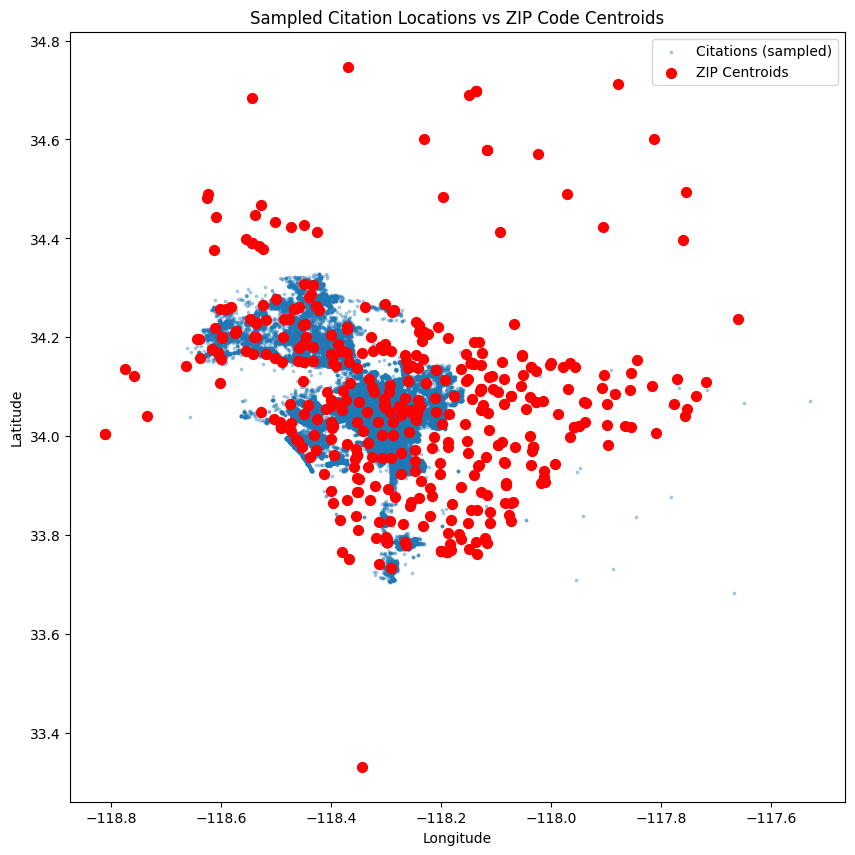

In [5]:
df_sampled = df_parking_citations.sample(n=100_000, random_state=42)

plt.figure(figsize=(10, 10))

plt.scatter(
    df_sampled['loc_long'],
    df_sampled['loc_lat'],
    s=3,
    alpha=0.3,
    label='Citations (sampled)'
)

plt.scatter(
    la_county_zips_clean['longitude'],
    la_county_zips_clean['latitude'],
    color='red',
    s=50,
    label='ZIP Centroids'
)

plt.legend()
plt.title("Sampled Citation Locations vs ZIP Code Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


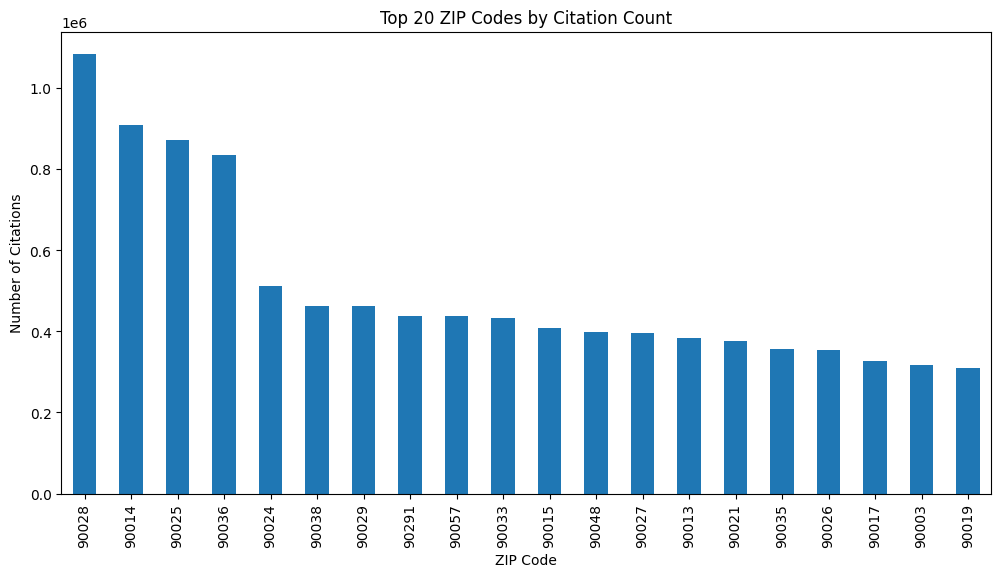

In [6]:
zip_counts = df_parking_citations['zip'].value_counts().head(20)

plt.figure(figsize=(12, 6))
ax = zip_counts.plot(kind='bar')
plt.title("Top 20 ZIP Codes by Citation Count")
plt.xlabel("ZIP Code")
plt.ylabel("Number of Citations")
plt.show()


In [7]:
# Ensure issue_date is datetime
df_parking_citations['issue_date'] = pd.to_datetime(df_parking_citations['issue_date'], format='%m/%d/%Y %I:%M:%S %p')

# Add day of the week
df_parking_citations['day_of_week'] = df_parking_citations['issue_date'].dt.day_name()

# Group by zip, date, and hour to get accurate counts
grouped_df = df_parking_citations.groupby(
    ['zip', 'issue_date', 'hour_issued', 'day_of_week']
).size().reset_index(name='ticket_count')

grouped_df.drop('issue_date', axis=1, inplace=True)

print(grouped_df.head(10))

     zip  hour_issued day_of_week  ticket_count
0  90001            5      Monday             1
1  90001           12      Friday             1
2  90001            9     Tuesday             2
3  90001           10   Wednesday             1
4  90001           16   Wednesday             1
5  90001            8    Thursday             1
6  90001           11    Thursday             1
7  90001           17    Thursday             7
8  90001            8      Friday             2
9  90001           11      Friday             1


In [8]:
grouped_df['hour_sin'] = np.sin(2 * np.pi * grouped_df['hour_issued'] / 24)
grouped_df['hour_cos'] = np.cos(2 * np.pi * grouped_df['hour_issued'] / 24)

grouped_df.drop('hour_issued', axis=1, inplace=True)

grouped_df.head(5)

,zip,day_of_week,ticket_count,hour_sin,hour_cos
0,90001,Monday,1,9.659258e-01,0.258819
1,90001,Friday,1,1.224647e-16,-1.000000
2,90001,Tuesday,2,7.071068e-01,-0.707107
3,90001,Wednesday,1,5.000000e-01,-0.866025
4,90001,Wednesday,1,-8.660254e-01,-0.500000


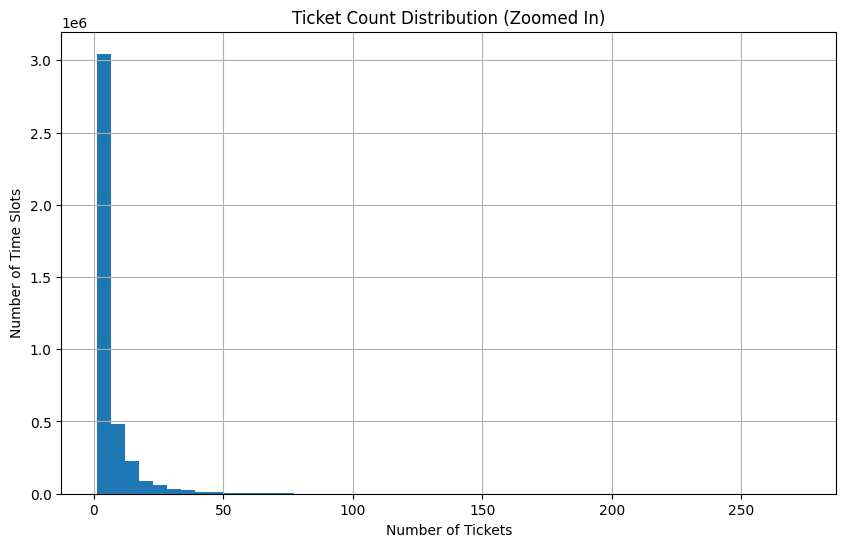

,zip,day_of_week,ticket_count,hour_sin,hour_cos
420519,90011,Friday,273,1.224647e-16,-1.000000
81237,90003,Monday,249,5.000000e-01,-0.866025
78496,90003,Tuesday,248,5.000000e-01,-0.866025
76347,90003,Tuesday,232,5.000000e-01,-0.866025
77070,90003,Tuesday,231,5.000000e-01,-0.866025
77372,90003,Tuesday,227,5.000000e-01,-0.866025
68019,90003,Tuesday,225,5.000000e-01,-0.866025
65679,90003,Tuesday,224,5.000000e-01,-0.866025
1026737,90025,Friday,224,5.000000e-01,-0.866025
65869,90003,Tuesday,223,5.000000e-01,-0.866025


In [9]:
plt.figure(figsize=(10, 6))
grouped_df['ticket_count'].hist(bins=50)
plt.title('Ticket Count Distribution (Zoomed In)')
plt.xlabel('Number of Tickets')
plt.ylabel('Number of Time Slots')
plt.grid(True)
plt.show()

grouped_df.sort_values('ticket_count', ascending=False).head(10)

In [10]:
# Step 1: Count how many rows each ZIP has
zip_counts = grouped_df['zip'].value_counts()

# Step 2: Keep only ZIPs with at least 50 entries
valid_zips = zip_counts[zip_counts >= 50].index

# Step 3: Replace all other ZIPs with 'other'
grouped_df['zip'] = grouped_df['zip'].apply(lambda z: z if z in valid_zips else 'other')

print(grouped_df['zip'].value_counts().head())
print("'other' in ZIPs:", 'other' in grouped_df['zip'].values)

zip
90028    77408
90025    71604
90036    66355
90014    62684
90029    59948
Name: count, dtype: int64
'other' in ZIPs: True


In [11]:
 # Ensure ZIPs are strings
grouped_df['zip'] = grouped_df['zip'].astype(str)

# One-hot encode 'zip' column using get_dummies
grouped_df = pd.get_dummies(grouped_df, columns=['zip'], prefix='zip')

In [12]:
def assign_risk(count):
  if count <= 3:
    return 'low'
  else:
    return 'high'


grouped_df['risk_level'] = grouped_df['ticket_count'].apply(assign_risk)

grouped_df.sample(5)

,day_of_week,ticket_count,hour_sin,hour_cos,zip_90001,zip_90002,zip_90003,zip_90004,zip_90005,zip_90006,...,zip_91748,zip_91765,zip_91767,zip_91768,zip_91769,zip_91776,zip_91793,zip_91803,zip_other,risk_level
3498966,Sunday,1,-5.000000e-01,-0.866025,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,low
1812031,Friday,6,8.660254e-01,0.500000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,high
494720,Monday,7,-7.071068e-01,-0.707107,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,high
515435,Tuesday,55,1.224647e-16,-1.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,high
2145131,Tuesday,3,1.224647e-16,-1.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,low


In [16]:
grouped_df['risk_level'].value_counts()

,count
risk_level,
low,2324064
high,1682547


In [ ]:
file_path_final_df = '/content/drive/My Drive/machine-learning/park-safe-la/data/Grouped_df.csv'
grouped_df.to_csv(file_path_final_df, index=False)

In [ ]:
grouped_df.shape

(4006611, 230)